<a href="https://colab.research.google.com/github/erichardson97/cell_crushers/blob/main/modelling/modelling_functions_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive, files
import pandas as pd
from typing import Union, Callable
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import pylab
import scipy.stats as stats
import os
import sklearn
%pip install striprtf
from striprtf.striprtf import rtf_to_text

drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/CMIPB_Files')


Mounted at /content/drive/


In [3]:
from utils import *

ModuleNotFoundError: ignored

In [13]:
# @title Read in file and specify target feature.
data = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/IntegratedData.tsv', sep = '\t', index_col = 0)
target = 'Day14_IgG_Titre'
data = data.rename(columns = {target: 'Target'})
data = data[data['Target']!='ND']
data['Target'] = data['Target'].map(float)
ds = Dataset(data)

In [11]:
import utils
from data_utils import Dataset

In [12]:
# @title Read in file and specify target feature.
data = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/Model1/NormalizedData.tsv', sep = '\t', index_col = 0)
target = 'Day14_IgG_Titre'
data = data.rename(columns = {target: 'Target'})
data = data[data['Target']!='ND']
data['Target'] = data['Target'].map(float)
ds = Dataset(data)


In [14]:
genes = list(pd.read_csv('/content/drive/MyDrive/CMIPB_Files/Model1/GeneList.txt',sep='\t')['Gene'].unique())
cellfreq = ['Cellfrequency_Bcells', 'Cellfrequency_ASCs (Plasmablasts)', 'Cellfrequency_TemraCD4']
cytokines = [p for p in pd.read_csv('/content/drive/MyDrive/CMIPB_Files/features_sans_target.txt', sep = '\t')['feature name'].values if 'Cytokine' in p]
all_features = genes + cellfreq + cytokines

In [6]:
# @title Functions for reading.

def read_sheet_url(url: str) -> pd.DataFrame:
  return pd.read_csv(url.replace('/edit#gid=', '/export?format=csv&gid='))

def read_rtf(file: str) -> set:
  with open(file.replace('rtf','tsv'), 'w') as k:
    k.write('\n'.join(rtf_to_text(open(file,'r').read()).split('UniProtKB'))[1:])
  genes = set(pd.read_csv(file.replace('rtf','tsv'), sep = '\t')['Gene'].unique())
  return genes

def read_rtf2(file: str) -> set:
  gene1 = rtf_to_text(open(file, 'r').read()).split('GO:')[0].split('\t')[-2]
  names = [p.split('\t')[-2] for p in rtf_to_text(open(file, 'r').read()).split('GO:')[1:]]
  names = [p.replace('UniProt','').replace('GO_Central','').replace('ComplexPortal','').replace('BHF-UCL', '').replace('Ensembl', '') for p in names]
  return set(names).union(set([gene1]))

In [18]:
# sciimm_features = list(pd.read_excel('EVE_HIPCTeam_SciImm_2017.xlsx')['Gene'])#list(set(['GEX_'+p for p in ]).intersection(set(data.columns)))
# julie_features = list(set(['LONP2', 'PAPSS2', 'EPHB1','ADAM12','SMC1A','RETN','CD101']))
%cd /content/drive/MyDrive/CMIPB_Files
bcellactivation = 'https://docs.google.com/spreadsheets/d/1WCi_VIJLipzaPQl6W2wK_yXzyzcBxLWd/edit#gid=1986511717'
bcelldifferentiation = 'https://docs.google.com/spreadsheets/d/1LkWdSaiakDqbJVRIDCUJiXAZOEV6fHUE/edit#gid=1705069152'
isotypeswitching = 'https://docs.google.com/spreadsheets/d/1GFmXIBYfTWccsKMW8OwEDyl6yynd0Mx1/edit#gid=1931371240'
bcellproliferation = 'https://docs.google.com/spreadsheets/d/1EgU8i_h-jvjEQ0Cx8tR6jx2h20P7U0_c/edit#gid=186885105'
go_sheets = {'Activation':read_sheet_url(bcellactivation)['Gene'].unique(),
             'Differentiation':read_sheet_url(bcelldifferentiation)['Gene'].unique(),
             'Isotype switching':read_sheet_url(isotypeswitching)['Gene'].unique(),
             'B-cell proliferation':read_sheet_url(bcellproliferation)['Gene'].unique()}
go_sheets['Plasma cell genes'] = set(['BCL6','CR1','C3BR','IL10','IL2','ITM2A','LGALS1','NFKBIZ','NKX2-3','XBP1'])
go_sheets['B cell activation'] = read_rtf('b_cell_activation.rtf')
go_sheets['IgG'] = read_rtf2('IgG_genes.rtf')
# go_sheets['Literature_features'] = sciimm_features+julie_features
all_genes = set().union(*[set(go_sheets[p]) for p in go_sheets])
all_genes = set(['GEX_'+p for p in all_genes])
in_dataset = all_genes.intersection(set(ds.data.columns))
in_dataset_df = {}
for k in in_dataset:
  in_dataset_df[k.split('_')[1]] = {}
  for p in go_sheets:
    if k.split('_')[1] in go_sheets[p]:
      in_dataset_df[k.split('_')[1]][p] = 1
in_dataset_df = pd.DataFrame(in_dataset_df).fillna(0).T

/content/drive/MyDrive/CMIPB_Files


In [21]:
class HyperparamSearch():
  def __init__(self, cv_object, data):
      self.cv_object = cv_object(data)

  def run_search(self, params: dict, cv_type: str, cv_args: dict):
      parameter_indices = {}
      cv_results_total = []
      for f, g in enumerate(ParameterGrid(params)):
          parameter_indices[f] = g
          cv_args['model_params'] = g
          cv_results = self.cv_object.run_cv(cv_type = cv_type, cv_args = cv_args)
          cv_results_total.append(cv_results)
      return cv_results_total, parameter_indices


In [43]:
def corr_coeff_report(y_pred: list, y_true: list) -> float:
  '''
  Function that returns Spearman's correlation coefficient between predictions
  and true target values.
  In contrast to corr_coeff, this is not a loss function.
  '''
  return spearmanr(y_pred, y_true)[0]

def corr_coeff(y_pred: list, y_true: list) -> float:
  '''
  Function that turns Spearman's correlation coefficient between predictions
  and true target values, into a loss (i.e. the smaller the coefficient/if coefficient is negative,
  the larger the loss).
  In contrast to corr_coeff_report, this IS to be used as a loss function (NB
  non-differentiable).
  '''
  return float(1 - spearmanr(y_pred, y_true)[0])

def return_property(model, string):
  return getattr(model, string)





class CV():

  def __init__(self, data: pd.DataFrame):
    self.data = data

  def RunCV(self, cv_args: dict, cv_type: str):
    if cv_type == 'LOOCV':
      return self.loocv(**cv_args)
    elif cv_type == 'RegularCV':
      return self.regular_ol_cv(**cv_args)
    elif cv_type == 'CrossDataset_Nested':
      return self.cross_dataset_CV_Nested(**cv_args)
    elif cv_type == 'CrossDataset':
      return self.cross_dataset_CV(**cv_args)


  def loocv(self, features: list, target: str, model_class):
    '''
    Function for Leave-one out cross-validation.
    Score is MSE, because there is only one sample.
    So cannot calculate a correlation coefficient.
    '''
    X = self.data[features].values
    y = self.data[target].values
    scores = {'Test':[], 'MSE':[]}
    trained_models = {}
    for train_idx, test_idx in KFold(n_splits = len(X)).split(X, y):
      train_X, train_y = X[train_idx], y[train_idx]
      test_X, test_y = X[test_idx], y[test_idx]
      model = model_class().fit(train_X, train_y)
      val = model.predict(test_X)
      mse = ((test_y - val)**2)[0]
      scores['Test'].append(test_idx[0])
      scores['MSE'].append(mse)
      trained_models[test_idx[0]] = model
    scores = pd.DataFrame(scores)
    return scores, trained_models


  def regular_ol_cv(self, features: list, target: str, n_splits: int, score_function: Callable, model_class, model_params: dict = {}, return_coef: str = 'coef_', normalize = True):
    '''
    Regular CV with no stratification by year.
    '''
    X = self.data[features].values
    baseline = self.data['Titre_IgG_PT'].values
    y = self.data[target].values
    fold = 0
    scores = {'Fold':[], 'Score':[], 'MSE':[], 'Baseline':[]}
    trained_models = {}
    for train_idx, test_idx in KFold(n_splits = n_splits, shuffle = True).split(X, y):
      train_X, train_y = X[train_idx], y[train_idx]
      test_X, test_y = X[test_idx], y[test_idx]
      if normalize:
        train_X = StandardScaler().fit_transform(train_X)
        train_y = StandardScaler().fit_transform(train_y.reshape(-1,1)).ravel()
        test_X = StandardScaler().fit_transform(test_X)
        test_y = StandardScaler().fit_transform(test_y.reshape(-1,1)).ravel()
      model = model_class(**model_params)
      model.fit(train_X, train_y)
      val = model.predict(test_X)
      score = score_function(test_y, val)
      scores['Fold'].append(fold)
      scores['Score'].append(score)
      scores['MSE'].append(mean_squared_error(test_y, val))
      scores['Baseline'].append(score_function(test_y, baseline[test_idx]))
      trained_models[fold] = model
      fold += 1
    scores = pd.DataFrame(scores)
    if return_coef:
      coefficient_df = pd.DataFrame(dict((p, return_property(trained_models[p], return_coef)) for p in trained_models)).T
      coefficient_df.columns = features
    else:
      coefficient_df = None
    return scores, trained_models, coefficient_df


  def cross_dataset_CV_Nested(self, features: list, target: str, n_splits: int, score_function: Callable, model_class, model_params: dict = {}, return_coef = 'coef_'):
    '''
    Nest CV i.e. train on 80% of 2020, test on 20% of 2021, etc.
    '''

    X_1 = self.data[self.data['dataset']=='2020_dataset'][features].values
    y_1 = self.data[self.data['dataset']=='2020_dataset'][target].values
    X_1_baseline = self.data[self.data['dataset']=='2020_dataset']['Titre_IgG_PT'].values
    X_2 = self.data[self.data['dataset']=='2021_dataset'][features].values
    y_2 = self.data[self.data['dataset']=='2021_dataset'][target].values
    X_2_baseline = self.data[self.data['dataset']=='2021_dataset']['Titre_IgG_PT'].values
    outer = 0
    scores = {'Score':[], 'Outer':[], 'Inner':[], 'Train_Year':[], 'Baseline':[]}
    trained_models = {}
    for train_idx, _ in KFold(n_splits = 5, shuffle=True).split(X_1, y_1):
        train_X, train_y = X_1[train_idx], y_1[train_idx]
        inner = 0
        for _, test_idx in KFold(n_splits = 5).split(X_2, y_2):
          test_X, test_y = X_2[test_idx], y_2[test_idx]
          model = model_class(**model_params).fit(train_X, train_y)
          val = model.predict(test_X)
          score = score_function(test_y, val)
          scores['Outer'].append(outer)
          scores['Inner'].append(inner)
          scores['Score'].append(score)
          scores['Train_Year'].append(2020)
          scores['Baseline'].append(score_function(X_2_baseline[test_idx], test_y))
          trained_models[f'{outer}_{inner}_2020'] = model
          inner += 1
        outer += 1
    for train_idx, _ in KFold(n_splits = 5).split(X_2, y_2):
        train_X, train_y = X_2[train_idx], y_2[train_idx]
        inner = 0
        for _, test_idx in KFold(n_splits = 5).split(X_1, y_1):
          test_X, test_y = X_1[test_idx], y_1[test_idx]
          model = model_class().fit(train_X, train_y)
          val = model.predict(test_X)
          score = score_function(test_y, val)
          scores['Outer'].append(outer)
          scores['Inner'].append(inner)
          scores['Score'].append(score)
          scores['Train_Year'].append(2021)
          scores['Baseline'].append(score_function(X_1_baseline[test_idx], test_y))
          trained_models[f'{outer}_{inner}_2021'] = model
          inner += 1
        outer += 1
    if return_coef:
      coefficient_df = pd.DataFrame(dict((p, return_property(trained_models[p], return_coef)) for p in trained_models)).T
      coefficient_df.columns = features
    else:
      coefficient_df = None
    scores = pd.DataFrame(scores)
    return scores, trained_models, coefficient_df


  def cross_dataset_CV(self, features: list, target: str, n_splits: int, score_function: Callable, model_class, model_params: dict = {}, return_coef = 'coef_'):
    '''
    Train on 2020 and test on 2021 and vice versa.
    '''
    X_1 = self.data[self.data['dataset']=='2020_dataset'][features].values
    baseline_X1 = self.data[self.data['dataset']=='2020_dataset']['Titre_IgG_PT']
    y_1 = self.data[self.data['dataset']=='2020_dataset'][target].values
    X_2 = self.data[self.data['dataset']=='2021_dataset'][features].values
    baseline_X2 = self.data[self.data['dataset']=='2021_dataset']['Titre_IgG_PT']
    y_2 = self.data[self.data['dataset']=='2021_dataset'][target].values
    outer = 0
    scores = {'Score':[], 'Train_Year':[], 'Test_Year':[], 'Baseline':[]}
    trained_models = {}
    train_X, train_y = X_1, y_1
    test_X, test_y = X_2, y_2
    model = model_class(**model_params).fit(train_X, train_y)
    trained_models['Train2020_Test2021'] = model
    val = model.predict(test_X)
    score = score_function(val, test_y)
    scores['Score'].append(score)
    scores['Train_Year'].append(2020)
    scores['Test_Year'].append(2021)
    scores['Baseline'].append(score_function(baseline_X2, test_y))
    model = model_class(**model_params).fit(test_X, test_y)
    trained_models['Train2021_Test2020'] = model
    val = model.predict(train_X)
    score = score_function(val, train_y)
    scores['Score'].append(score)
    scores['Train_Year'].append(2021)
    scores['Test_Year'].append(2020)
    scores['Baseline'].append(score_function(baseline_X1, train_y))
    scores = pd.DataFrame(scores)
    if return_coef:
      coefficient_df = pd.DataFrame(dict((p, return_property(trained_models[p], return_coef)) for p in trained_models)).T
      coefficient_df.columns = features
    else:
      coefficient_df = None
    return scores, trained_models, coefficient_df

In [25]:
julie_functions = read_sheet_url('https://docs.google.com/spreadsheets/d/141sdNbM26DXoj5Zb8fkINU7IscQdNLYk/edit#gid=76743725')
gene_counts = pd.DataFrame({'count':dict(julie_functions['Gene'].value_counts())}).sort_values('count', ascending = False)

In [32]:
other_features = {'Cellfrequency':['Bcells','CD4Tcells','TemraCD4','NaiveCD4','TemCD4','TcmCD4','ASCs (Plasmablasts)'],
                  'Cytokine':['IL6','CCL8','CXCL10','CCL3','IFNG','TNF']}
total = set().union(*[set([p+'_'+z for z in other_features[p]])for p in other_features])
total.update(set(['GEX_'+p for p in in_dataset_df.index]))

In [35]:
len(feature_list)

421

In [33]:
feature_list =  list(set(['GEX_'+p for p in set(gene_counts.index)]).intersection(set(data.columns))) + list(total)
features_sans_target = list(set(feature_list).difference(set(['dataset', 'Target'])))

In [36]:
with open('features_sans_target.txt', 'w') as k:
  k.write('feature name\n')
  k.write('\n'.join(features_sans_target))

In [65]:
m = pd.read_csv('/content/drive/MyDrive/CMIPB_Files/example/DataWithCorrelationFiltering.csv', index_col = 0)
ds = Dataset(m)

In [84]:
demographic = ['age', 'Titre_IgG_PT','biological_sex', 'infancy_vac']
cell_freqs = ['Cellfrequency_TcmCD4', 'Cellfrequency_TemCD4', 'Cellfrequency_Bcells','Cellfrequency_ASCs (Plasmablasts)']
genes = [p for p in ds.data.columns if 'GEX' in p]
cytokines = [p for p in features_sans_target if 'Cytokine' in p]
cytokines.remove('Cytokine_IFNG')
cytokines.remove('Cytokine_TNF')
candidate_features = cell_freqs + demographic + genes + cytokines

In [88]:

args = {'target':'Target', 'n_splits':5, 'score_function':corr_coeff_report,
        'model_params':{'alpha':0.1}, 'model_class':Lasso,
        'return_coef':'coef_', 'features':candidate_features}
ds.filter(list(genes))
cvobj = CV(ds.data)
total = []
coefs_ = []
for f in range(10):
  output, _, coefs = cvobj.RunCV(cv_type='RegularCV', cv_args=args)
  output['repeat'] = f
  coefs['repeat'] = f
  total.append(output)
  coefs_.append(coefs)
total = pd.concat(total)
coefs_ = pd.concat(coefs_)

In [47]:
feature_list =  list(set(['GEX_'+p for p in set(gene_counts.index)]).intersection(set(data.columns))) + list(total)
features_sans_target = list(set(feature_list).difference(set(['dataset', 'Target'])))
ds = Dataset(data)
ds.filter(['Cellfrequency_Bcells','Cellfrequency_NaiveCD4'])
ds.make_float(['Cellfrequency_Bcells','Cellfrequency_NaiveCD4'])
ds.normalize(list(set(['Cellfrequency_Bcells','Cellfrequency_NaiveCD4','Titre_IgG_PT']).difference(set(['dataset']))))

args = {'target':'Target', 'n_splits':5, 'score_function':corr_coeff_report,
        'model_params':{}, 'model_class':LinearRegression,
        'return_coef':'coef_', 'features':['Cellfrequency_Bcells','Cellfrequency_NaiveCD4'] + ['Titre_IgG_PT','age']}

cvobj = CV(ds.data)
total = []
coefs_ = []
for f in range(10):
  output, _, coefs = cvobj.RunCV(cv_type='RegularCV', cv_args=args)
  output['repeat'] = f
  coefs['repeat'] = f
  total.append(output)
  coefs_.append(coefs)
total = pd.concat(total)
coefs_ = pd.concat(coefs_)

NameError: ignored

In [62]:
from sklearn.feature_selection import RFE
estimator = Lasso(alpha=0.1)
args = {'target':'Target', 'n_splits':5, 'score_function':corr_coeff_report,
        'model_params':{'estimator':estimator, 'n_features_to_select':0.5}, 'model_class':RFE,
        'return_coef':'ranking_', 'features':genes + ['Titre_IgG_PT','age']}
cvobj = CV(ds.data)
total = []
coefs_ = []
for f in range(10):
  output, _, coefs = cvobj.RunCV(cv_type = 'CrossDataset', cv_args=args)
  output['repeat'] = f
  coefs['repeat'] = f
  total.append(output)
  coefs_.append(coefs)
total = pd.concat(total)
coefs_ = pd.concat(coefs_)



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e+00, tolerance: 1.053e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e+00, tolerance: 1.053e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

In [102]:
feature_list =  list(set(['GEX_'+p for p in set(gene_counts[gene_counts['count']>=2].index).union(set(in_dataset_df.index))]).intersection(set(data.columns)))
#feature_list = ['GEX_PLCG2', 'GEX_LYN','GEX_VAV1']
ds = Dataset(data)
ds.filter(feature_list)
ds.make_float([p for p in feature_list if p != 'dataset'])
ds.normalize(list(set(feature_list).difference(set(['dataset']))))
features_sans_target = list(set(feature_list).difference(set(['dataset','Target'])))
cvobj = CV(ds.data_normalized)
# regular_ol_cv(ds.data_normalized, features_sans_target+['Titre_IgG_PT'], 'Target', n_splits = 5, score_function = corr_coeff_report, model_params={'max_features':'sqrt'}, model_class = RandomForestRegressor, return_coef='feature_importances_')#, model_params = {'alpha':1})
# print(output)

<ipython-input-54-a5b40386ff81>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  self.data_filtered = self.data[~(self.data[self.feature_list].applymap(lambda x:x=='ND')!=False).any(1)][self.feature_list]


In [104]:
args = {'target':'Target', 'n_splits':5, 'score_function':corr_coeff_report,
        'model_params':{'alpha':0.1}, 'model_class':Lasso,
        'return_coef':'coef_', 'features':features_sans_target}


output = cvobj.RunCV(cv_type='RegularCV', cv_args=args)

In [ ]:
ds = Dataset(data)
feature_list =  list(set(['GEX_'+p for p in set(gene_counts[gene_counts['count']>=2].index)]).intersection(set(data.columns)))
ds.filter(feature_list)
ds.make_float([p for p in feature_list if p != 'dataset'])
ds.normalize(list(set(feature_list).difference(set(['dataset','age']))))
total = []
for feat in feature_list:
  for f in range(10):
    output, models, _ = regular_ol_cv(ds.data_normalized, [feat]+['Titre_IgG_PT'], 'Target', n_splits = 5, score_function = corr_coeff_report, model_class = LinearRegression)#$, model_params = {'alpha':1})
    output['feature'] = feat
    output['repeat'] = f
    total.append(output)
total = pd.concat(total)

<Axes: xlabel='feature', ylabel='value'>

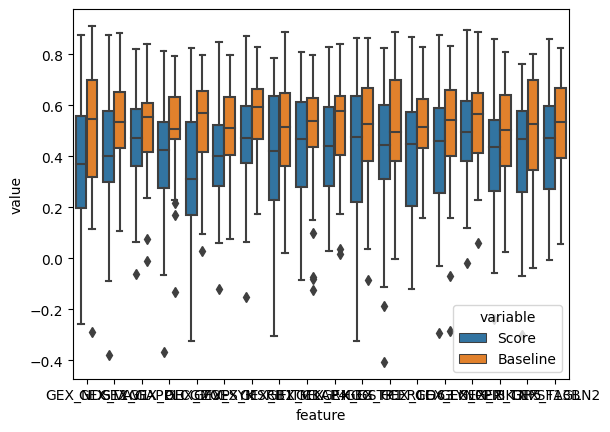

In [ ]:
sns.boxplot(data = total.melt(id_vars=['feature','Fold'],value_vars=['Score','Baseline']), x = 'feature', y = 'value', hue = 'variable')

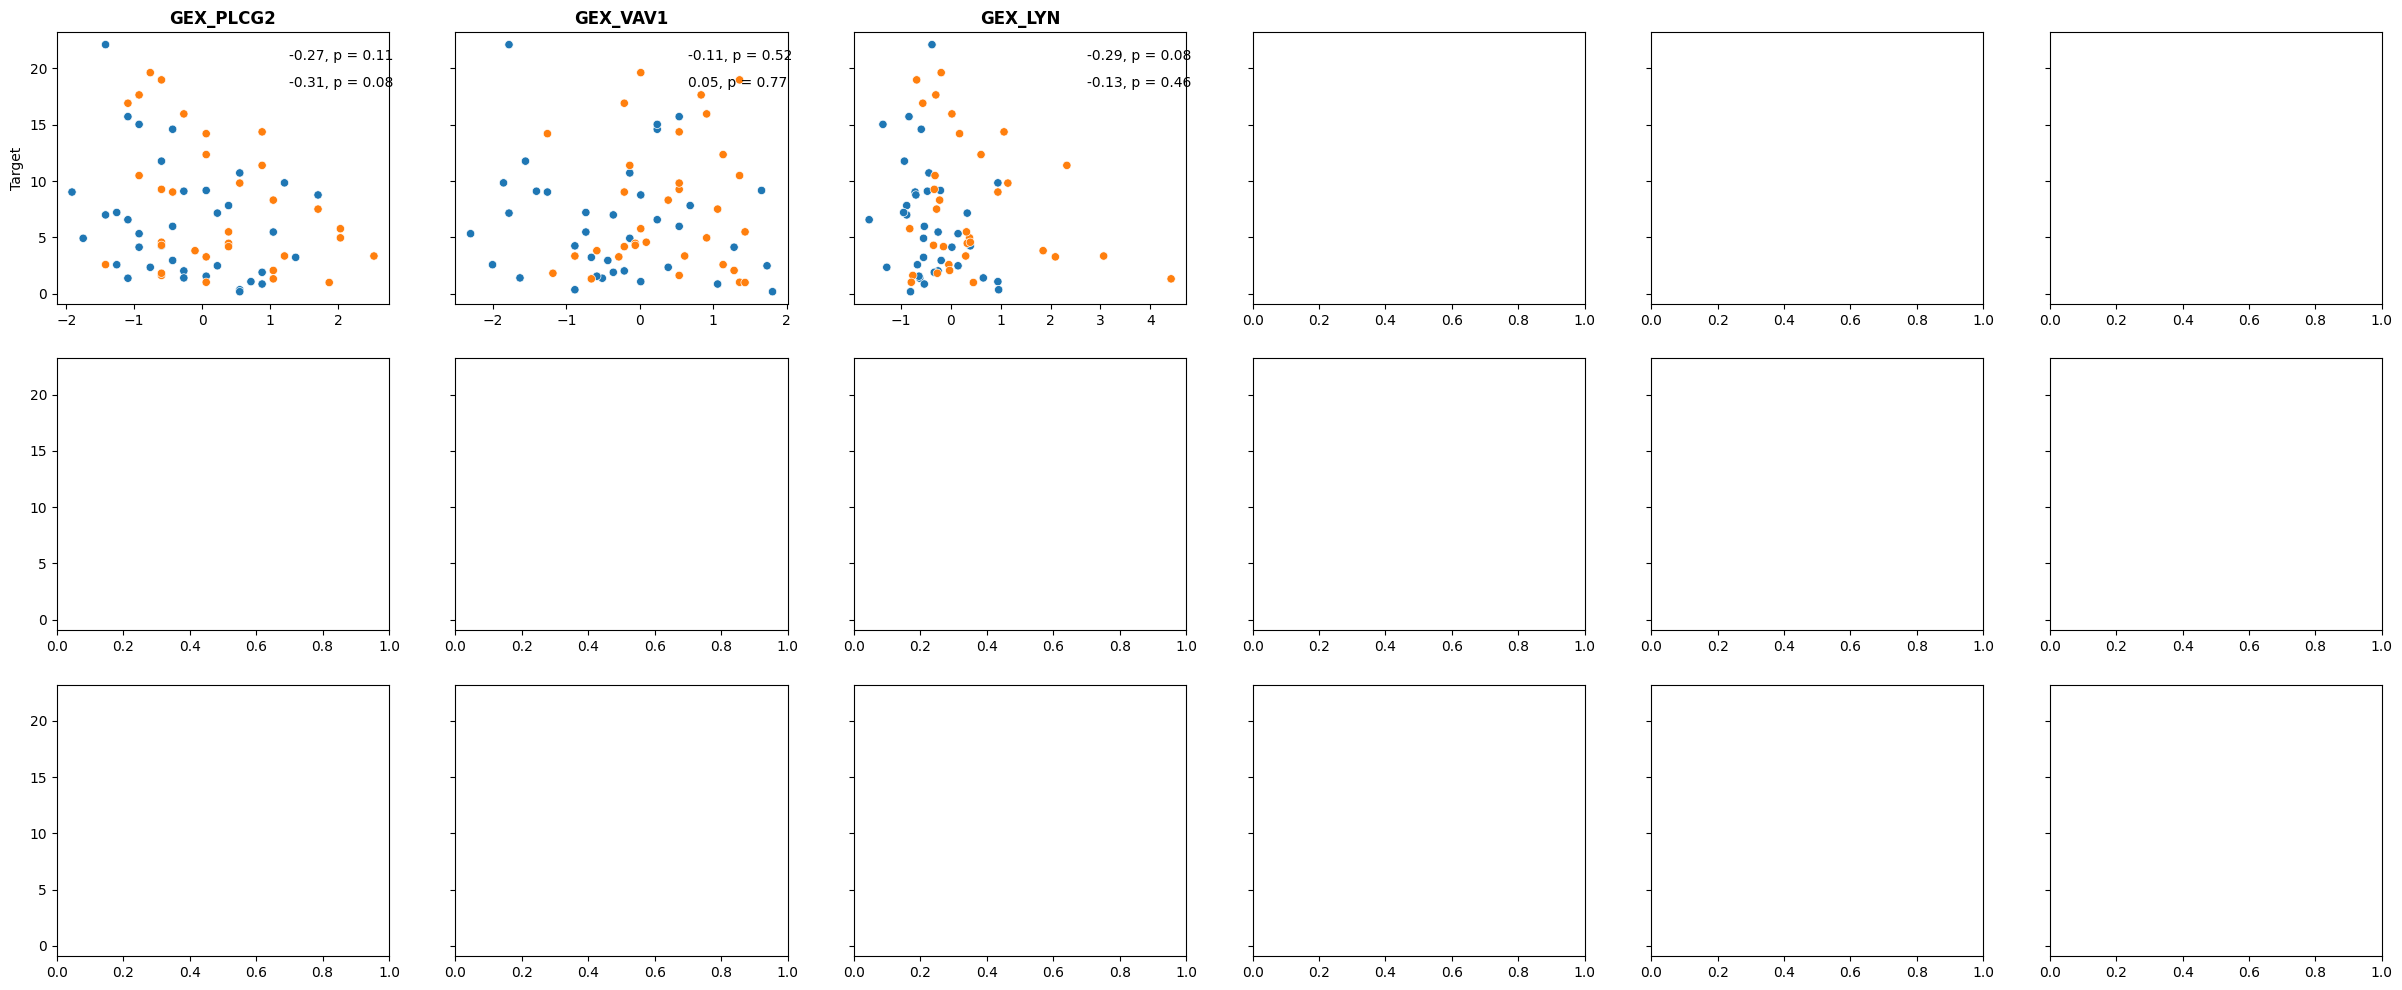

In [ ]:
fig, ax = plt.subplots(3, 6, figsize=(30,12), sharey=True)

values = {}
for k,p in enumerate(features_sans_target):
  axis = ax[int(k/6)][k%6]
  sns.scatterplot(data = ds.data_normalized, x = p, y = 'Target', hue = 'dataset', ax = axis)
  axis.set_title(p, fontweight='bold')
  axis.set_xlabel('')
  d2020 = ds.data_normalized[ds.data_normalized['dataset']=='2020_dataset']
  val2020, pval2020 = spearmanr(d2020[p],d2020['Target'])
  xlim = axis.get_xlim()
  ylim = axis.get_ylim()
  axis.text(x=xlim[1]-0.3*(xlim[1]-xlim[0]), y=ylim[1]-0.1*(ylim[1]-ylim[0]),s= f'{val2020:.2f}, p = {pval2020:.2f}')
  d2021 = ds.data_normalized[ds.data_normalized['dataset']=='2021_dataset']
  val2021, pval2021 = spearmanr(d2021[p],d2021['Target'])
  xlim = axis.get_xlim()
  ylim = axis.get_ylim()
  values[p] = max([val2020, val2021])/min([val2020, val2021])
  axis.text(x=xlim[1]-0.3*(xlim[1]-xlim[0]), y=ylim[1]-0.2*(ylim[1]-ylim[0]),s= f'{val2021:.2f}, p = {pval2021:.2f}')
  axis.get_legend().remove()

In [ ]:
from sklearn.linear_model import LogisticRegression
hyperparam_search = {'alpha':[.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
vals = HyperparamSearch()
vals_out = vals.run_search(params = hyperparam_search, cv_func = regular_ol_cv, cv_args = {'data':ds.data_normalized, 'features': features_sans_target+['age','Titre_IgG_PT'], 'target':'Target', 'n_splits':5, 'score_function':corr_coeff_report, 'model_class': Lasso})

In [ ]:
scores = pd.concat([x[0].assign(params = p) for p,x in enumerate(vals_out[0])])
scores['regularization'] = scores['params'].map(lambda x:vals_out[1][x]['alpha'])

In [ ]:
scores_flat = scores.melt(id_vars=['regularization'],value_vars=['Score','Baseline'])
ax = sns.boxplot(data = scores_flat, x = 'regularization', y = 'value', hue = 'variable')

In [ ]:
## Adapted from: https://alexmiller.phd/posts/linear-model-custom-loss-function-regularization-python/
##I added a second regularization, which is the "unreliabilities".
##This is intended to minimize coefficients for features that had
##conflicting correlation coefficients between batches.
##If no unreliabilities are supplied, that part of the loss
##disappears.

class CustomRidge:
    """
    Linear model: Y = XB, fit by minimizing the provided loss_function
    with L2 regularization
    """
    def __init__(self, loss_function=corr_coeff,
                 X=None, Y=None, sample_weights=None, beta_init=None,
                 regularization=0.000012, unreliabilities=None, method='nelder-mead'):
        self.regularization = regularization
        self.beta = None
        self.loss_function = loss_function
        self.sample_weights = sample_weights
        self.beta_init = beta_init
        self.unreliabilities = unreliabilities


    def predict(self, X):
        prediction = np.matmul(X, self.beta[:self.X.shape[1]])
        return(prediction)

    def model_error(self):
        error = self.loss_function(
            self.predict(self.X), self.Y
        )
        return(error)

    def l2_regularized_loss(self, beta):
        self.beta = beta
        print(self.beta)
        return(self.model_error() + \
               sum(self.regularization*np.array(self.beta[:self.X.shape[1]])**2)+
               sum(self.beta[:self.X.shape[1]]*self.beta[self.X.shape[1]:]))

    def fit(self, X, Y, maxiter=250):
        self.X = X
        self.Y = Y
        if type(self.unreliabilities) == type(None):
              self.unreliabilities = np.zeros(self.X.shape[1])
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.hstack([np.array([1]*self.X.shape[1]),self.unreliabilities])
        else:
          self.beta_init = np.hstack([self.beta_init, self.unreliabilities])
          #  self.beta_init = np.reshape(np.stack([np.array([1]*self.X.shape[1]),self.unreliabilities], axis = 1), (2, self.X.shape[1], 2))

        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more iterations.")
        print(self.beta_init)
        res = minimize(self.l2_regularized_loss, self.beta_init,
                       method='nelder-mead', options={'maxiter': 500})
        self.beta = res.x
        self.beta_init = self.beta
        self.coef_ = self.beta[:self.X.shape[1]]
        return self